<a href="https://colab.research.google.com/github/CthulhuCoder01/rnn-model-to-check-country-by-name/blob/main/Name_Country_Modal_RNN_Using_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://download.pytorch.org/tutorial/data.zip


--2023-06-01 12:34:00--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.228.31, 13.226.228.25, 13.226.228.114, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.228.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.1s    

2023-06-01 12:34:00 (18.9 MB/s) - ‘data.zip’ saved [2882130/2882130]



In [2]:
!unzip *.zip

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


 # This is a multiclass clasification as there are so many diffrent names

In [3]:
import os
import numpy as np
import unicodedata
import string

import torch
import torch.nn as nn



In [4]:

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)


In [5]:

def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn'
      and c in all_letters
  )



In [30]:
all_names = []
all_country = []

In [31]:

for f in  os.listdir('/content/data/names'):
    fl = open("/content/data/names/"+f, "r")
    lis = fl.readlines()
    clean_lis = list(map(unicodeToAscii,lis))
    all_names.extend(clean_lis)
    country_name = f.split(".")[0]
    all_country.extend( [ country_name ]  * len(clean_lis) )



In [106]:
print(all_names)
print(all_country)
print(len(all_names))

['Aalsburg', 'Aalst', 'Aarle', 'Achteren', 'Achthoven', 'Adrichem', 'Aggelen', 'Agteren', 'Agthoven', 'Akkeren', 'Aller', 'Alphen', 'Alst', 'Altena', 'Althuis', 'Amelsvoort', 'Amersvoort', 'Amstel', 'Andel', 'Andringa', 'Ankeren', 'Antwerp', 'Antwerpen', 'Apeldoorn', 'Arendonk', 'Asch', 'Assen', 'Baarle', 'Bokhoven', 'Breda', 'Bueren', 'Buggenum', 'Buiren', 'Buren', 'Can', 'Cann', 'Canne', 'Daal', 'Daalen', 'Dael', 'Daele', 'Dale', 'Dalen', 'Laar', 'Vliert', 'Akker', 'Andel', 'Denend', 'Aart', 'Beek', 'Berg', 'Hout', 'Laar', 'See', 'Stoep', 'Veen', 'Ven', 'Venn', 'Venne', 'Vennen', 'Zee', 'Donk', 'Haanraads', 'Haanraats', 'Haanrade', 'Haanrath', 'Haenraats', 'Haenraets', 'Hanraets', 'Hassel', 'Hautem', 'Hautum', 'Heel', 'Herten', 'Hofwegen', 'Horn', 'Hout', 'Houte', 'Houtem', 'Houten', 'Houttum', 'Houtum', 'Kan', 'Kann', 'Kanne', 'Kappel', 'Karl', 'Kikkert', 'Klein', 'Klerk', 'Klerken', 'Klerks', 'Klerkse', 'Klerkx', 'Klerx', 'Kloet', 'Kloeten', 'Kloeter', 'Koeman', 'Koemans', 'Kolen',

In [33]:
n_rows = len(all_names)

Now Comes One Hot Embedding to generate input for RNN model

In [38]:
# This emb is identity matrix of size n_letters x n_letters
emb = torch.eye(n_letters)
#mapping is done this way becuse maye all elemtns are unique to get range of all
mapping = dict(zip(np.unique(all_country), range(n_rows)))



## Converting name into char

In [87]:
def get_data(idx):
  name = all_names[idx]
  country = all_country[idx]
  name_char_lis = np.array(list(name))
  # Search through the np array name-charlist then convert it to a column array then 
  # Find index of letters from whole letter  porpose to get numerical value
  indices = np.where(name_char_lis[..., None] == np.array(list(all_letters)))[1]
  # Now we will get country code as in form of tensor and all indices in
  # Form of numpy array in form of embeded with one hot encodin
  # print(indices)
  # Now as emb has n_letters of charaters here hot encoding based on all charaters not max
  # chereter here
  # Here mapping is country dict we created earlies with all unique country
  return emb[torch.from_numpy(indices)], torch.tensor(mapping[country])



## Here we will define an RNN 

In [76]:
class Net(nn.Module):

  def __init__(self, n_country, n_letters):
    super(Net, self).__init__()
    self.rnn = nn.RNN(n_letters, 2 * n_letters)
    # This is last layer multiplication for outcome with n_country instead of 1 because of
    # multilevel Nural network
    #Shape of linear modal
    self.fc = nn.Linear(2 * n_letters, n_country)

  def forward(self,x):
    out, _ = self.rnn(x)
    # Now take value from last step of rnn using out[-1,:] and give result to user
    out1 = self.fc(out[-1,:])
    return out1



In [50]:

n_countries = len(np.unique(all_country))
model = Net(n_country=n_countries, n_letters=n_letters)



In [125]:
# Loss function i.e Cross Entropy loss function
loss_fn = nn.CrossEntropyLoss()
# Gradient Desent
optimizer = torch.optim.SGD(model.parameters(), lr= 0.005)


In [ ]:
num_epochs = 100
all_losses = []
for epoch in range(num_epochs):
  arr = np.arange(n_rows) # 0, 1, --- 20074
  np.random.shuffle(arr) # shuffle it
  epoch_loss = 0
  for ind in arr:
    data, target = get_data(ind) # data is indices vector in one hot form and target in tensor of country code
    output = model(data)
    # This will use cross entropy loss function to calculate loss
    loss = loss_fn(output, target)
    epoch_loss += loss.detach().numpy()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  all_losses.append(epoch_loss)


[78482.53886110762, 81445.05330827493, 82266.44693056495, 81783.32418632045, 81134.94203305022, 81076.69867806415, 81846.38106602401, 81545.2491079506, 80830.95595323038, 81600.91095531883, 84473.74635889879, 82101.5599480305, 81531.73433998358, 81857.3758890267, 81613.68350719244, 81730.64035290347, 81488.92232680843, 82021.75424120021, 82395.1876735711, 82118.21873313804, 82018.88049889028, 81407.45759443706, 81615.1054132529, 81202.54049457563, 81208.99596637803, 81496.69373524208, 81798.48873102924, 81919.67275154912, 81964.82143077062, 82030.97573792053, 82184.08928123681, 82204.82851950273, 83626.25272516228, 83630.4365611551, 83645.3791065618, 83374.9486199709, 83925.47540193377, 82900.93474796618, 83435.77477506621, 83473.58258776461, 83946.30968534859, 83661.90328015291, 83715.70983667517, 83997.4923922022, 83615.90941372792, 83550.32715415921, 83721.8326795905, 84000.34346585195, 83253.05775628454, 83746.32835778665, 83788.883948028, 83674.19044034515, 83825.1689039094, 83313

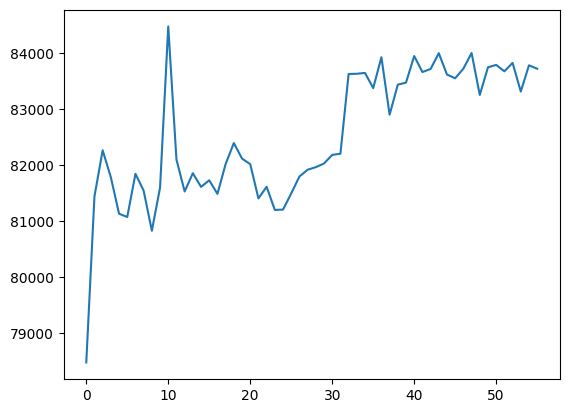

In [122]:
import matplotlib.pyplot as plt
# We can also live plot the neural network to get its value
plt.plot(all_losses)
print(all_losses)


In [ ]:
def textToLinear(name):
  name_char_lis = np.array(list(name))
  indices = np.where(name_char_lis[..., None] == np.array(list(all_letters)))[1]
  # Now we will get country code as in form of tensor and all indices in
  # Form of numpy array in form of embeded with one hot encodin
  # print(indices)
  # Now as emb has n_letters of charaters here hot encoding based on all charaters not max
  # chereter here
  # Here mapping is country dict we created earlies with all unique country
  return emb[torch.from_numpy(indices)]


In [118]:


# This uses tensors ans input
data, target = get_data(100)
# nameTensor = get_data(10)
output =  model(data)
predicted_labels = output.argmax()
correct_predictions = (predicted_labels == target)
# print("Predicted labels:", predicted_labels)
# print("Target labels:", target)

accuracy = torch.mean(correct_predictions.float())

print("Accuracy:", accuracy.item())

Accuracy: 0.0


## Now Ploting Evaluation of results

In [ ]:


#Take 10000 values randomize them feed data to model get result 
# Cheaack how close is the result to data then give value  



